In [88]:
# import sys
# sys.path.append('/home/jp/.snap/snap-python')

import math
from uuid import uuid1

from scipy.optimize import fsolve
from scipy import special
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gengamma

class GeneralizedGamma():

    def __init__(self, data, verbose=False, plot=False):
        self.verbose = verbose
        converted_data = np.asarray(data)
        # if self.verbose:
        #     print(converted_data)
        self.data = converted_data[converted_data != 0]
        self.N = len(self.data)
        if self.verbose:
            print(f'Número de pixels: {self.N}')

        # Assign experimental values using 
        # the method of log cumulants
        self.c1 = sum([math.log(x) for x in self.data])/self.N
        self.c2 = sum([(math.log(x) - self.c1)**2 for x in self.data])/self.N
        self.c3 = sum([(math.log(x) - self.c1)**3 for x in self.data])/self.N

        # Solve for the unknown parameters
        self.solve()
        if plot:
            self.plot()
            self.plot_pure()

    def equations(self, vars):
        # Define the system of equations
        sigma, kappa, v = vars
        eq1 = -self.c1 + math.log(sigma) + (special.polygamma(0, kappa) - math.log(kappa))/v  
        eq2 = -self.c2 + special.polygamma(1, kappa)/v**2
        eq3 = -self.c3 + special.polygamma(2, kappa)/v**3
        return [eq1, eq2, eq3]
    
    def solve(self):
        initial_guess = [1.0, 1.0, 1.0] # Initial guess for sigma, kappa and v
        solution = fsolve(self.equations, initial_guess)
        self.sigma_hat, self.kappa_hat, self.v_hat = solution

        if self.verbose:
            print(f"sigma = {self.sigma_hat}")
            print(f"kappa = {self.kappa_hat}")
            print(f"v = {self.v_hat}")

    def function_value(self, z):
        part1 = abs(self.v_hat) * (self.kappa_hat**self.kappa_hat)
        part2 = self.sigma_hat * special.gamma(self.kappa_hat)
        part3 = (z/self.sigma_hat) ** (self.kappa_hat*self.v_hat -1)
        part4 = np.exp(-self.kappa_hat*((z/self.sigma_hat)**self.v_hat))

        return (part1/part2) * part3 * part4

    def function_value_scipy(self):
        return gengamma(self.v_hat, self.kappa_hat)
    
    def function_value_scipy_scaled(self):
        return gengamma(self.v_hat, self.kappa_hat, scale=self.sigma_hat)
    
    def plot(self):
        x = np.linspace(1, 255, 300)
        y = self.function_value(x) * 4300

        plt.figure(figsize=(8, 6))  # Optional: Set the figure size

        plt.hist(self.data, bins=300)
        plt.plot(x, y, label='General gamma function', color='blue')  # Plot the function
        plt.xlabel('x')  # Label for the x-axis
        plt.ylabel('y')  # Label for the y-axis
        plt.title('Plot of f(x)')  # Title of the plot
        plt.legend()  # Display the legend
        plt.grid(True)  # Enable gridlines

        name = str(uuid1())
        plt.savefig('export/'+name+'.png', dpi=300, bbox_inches='tight') 

    def plot_pure(self):
        x = np.linspace(1, 255, 300)
        y = self.function_value(x)

        plt.figure(figsize=(8, 6))  # Optional: Set the figure size

        plt.plot(x, y, label='General gamma function', color='blue')  # Plot the function
        plt.xlabel('x')  # Label for the x-axis
        plt.ylabel('y')  # Label for the y-axis
        plt.title('Plot of f(x)')  # Title of the plot
        plt.legend()  # Display the legend
        plt.grid(True)  # Enable gridlines

        name = str(uuid1())
        plt.savefig('export/'+name+'.png', dpi=300, bbox_inches='tight') 

    def plot_scipy(self):
        gg = self.function_value_scipy()
        # x = np.linspace(1, 255, 300)
        x = np.linspace(gengamma.ppf(0.01, self.v_hat, self.kappa_hat),
                gengamma.ppf(0.99, self.v_hat, self.kappa_hat), 100)
        y = gengamma.pdf(x, self.v_hat, self.kappa_hat)

        plt.figure(figsize=(8, 6))  # Optional: Set the figure size

        plt.plot(x, y, label='General gamma function', color='blue')  # Plot the function
        plt.xlabel('x')  # Label for the x-axis
        plt.ylabel('y')  # Label for the y-axis
        plt.title('Plot of f(x)')  # Title of the plot
        plt.legend()  # Display the legend
        plt.grid(True)  # Enable gridlines

        name = str(uuid1())
        plt.savefig('export/'+name+'.png', dpi=300, bbox_inches='tight') 


    def plot_scipy_scaled(self):
        gg = self.function_value_scipy()
        # x = np.linspace(1, 255, 300)
        x = np.linspace(gengamma.ppf(0.01, self.v_hat, self.kappa_hat, scale=self.sigma_hat),
                gengamma.ppf(0.99, self.v_hat, self.kappa_hat, scale=self.sigma_hat), 100)
        y = gengamma.pdf(x, self.v_hat, self.kappa_hat, scale=self.sigma_hat)

        plt.figure(figsize=(8, 6))  # Optional: Set the figure size

        plt.plot(x, y, label='General gamma function', color='blue')  # Plot the function
        plt.xlabel('x')  # Label for the x-axis
        plt.ylabel('y')  # Label for the y-axis
        plt.title('Plot of f(x)')  # Title of the plot
        plt.legend()  # Display the legend
        plt.grid(True)  # Enable gridlines

        name = str(uuid1())
        plt.savefig('export/'+name+'.png', dpi=300, bbox_inches='tight') 


    def return_scipy_data(self):
        gg = self.function_value_scipy()
        # x = np.linspace(1, 255, 300)
        x = np.linspace(1, 15, 100)
        y = gengamma.pdf(x, self.v_hat, self.kappa_hat)

        return x, y
    
    def likelihood_distance(self, z, w, spatial_distance):

        # return self.function_value(z)
        # if spatial_distance == 0:
        #     spatial_distance = 0.000001
        probability = self.function_value(z)
        s_f = 1 - np.exp(-probability)
        return s_f
        # s_d = 1 - np.exp(-1/spatial_distance)
        # ml_distance = w*s_f + ((1-w)*s_d)

        # return ml_distance

    def normalized(self, z):
        from scipy.integrate import quad
        part1 = abs(self.v_hat) * (self.kappa_hat**self.kappa_hat)
        part2 = self.sigma_hat * special.gamma(self.kappa_hat)
        part3 = (z/self.sigma_hat) ** (self.kappa_hat*self.v_hat -1)
        part4 = np.exp(-self.kappa_hat*((z/self.sigma_hat)**self.v_hat))
        # Calculate the normalization constant C
        integral_result, _ = quad(self.normalized, -np.inf, np.inf)
        C = 1.0 / integral_result

        # Normalize the PDF
        normalized_pdf = C * (part1/part2) * part3 * part4

        return normalized_pdf
    
    def plot_normalized(self):
        x = np.linspace(1, 255, 300)
        y = self.normalized(x)

        plt.figure(figsize=(8, 6))  # Optional: Set the figure size

        plt.plot(x, y, label='General gamma function', color='blue')  # Plot the function
        plt.xlabel('x')  # Label for the x-axis
        plt.ylabel('y')  # Label for the y-axis
        plt.title('Plot of f(x)')  # Title of the plot
        plt.legend()  # Display the legend
        plt.grid(True)  # Enable gridlines

        # name = str(uuid1())
        # plt.savefig('export/'+name+'.png', dpi=300, bbox_inches='tight') 

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

import maskslic as seg
import skimage2.segmentation as seg2


#vv_src = rasterio.open('data/VV_VH.tif')
#vv = vv_src.read()
vv = imread('data/VV_VH.tif')

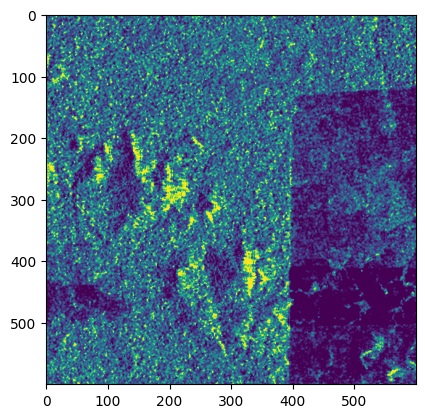

In [6]:
image = vv[0:600, 0:600]
plt.imshow(image)

Número de pixels: 18520
sigma = 30.994417092709803
kappa = 4.109771315834825
v = 0.446514174760206


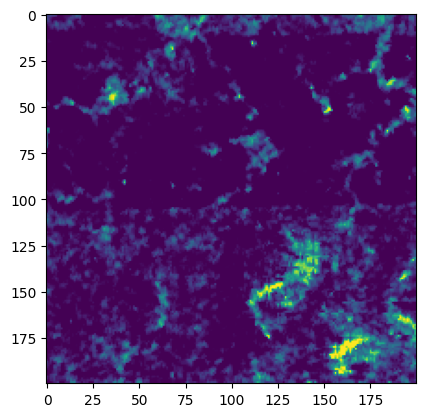

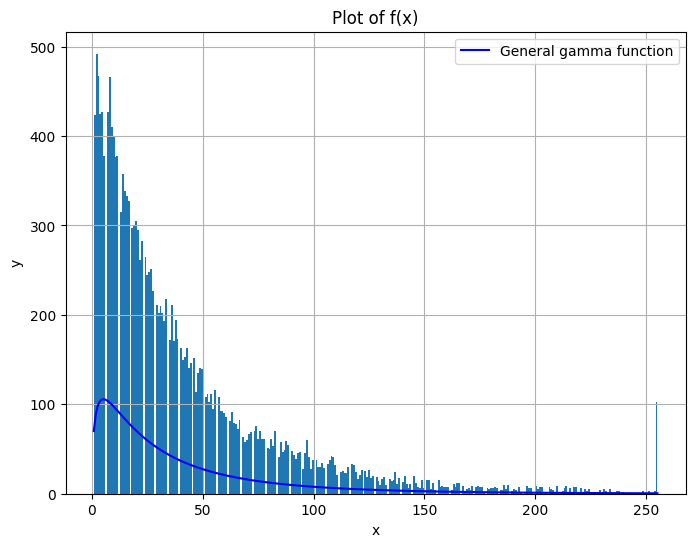

In [40]:
seg1 = vv[400:600, 400:600]
plt.imshow(seg1)
gama1 = GeneralizedGamma(seg1, True, True)

Número de pixels: 38681
sigma = 111.9591804956696
kappa = 0.791028672671812
v = 1.7906933755068333


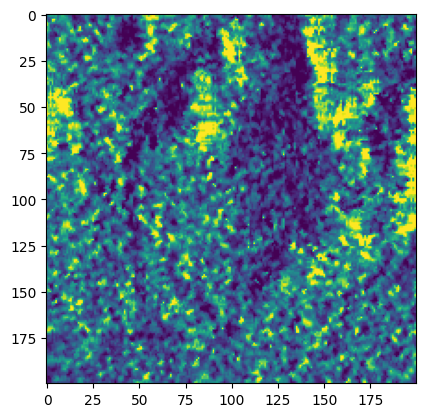

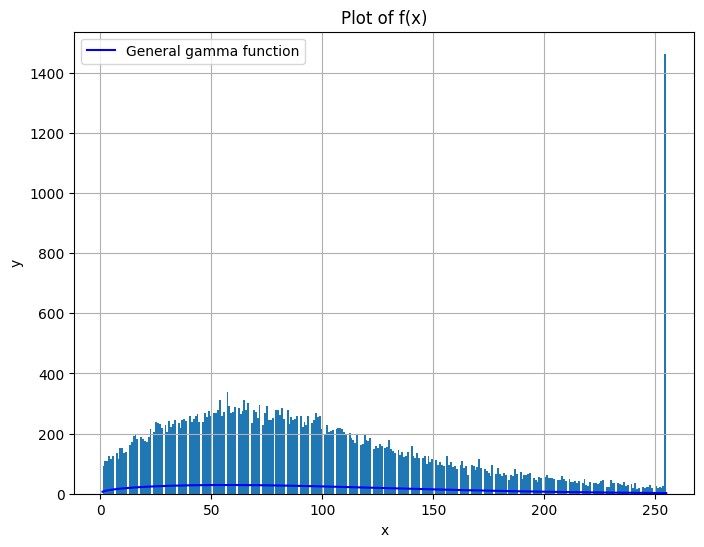

In [29]:
seg3 = vv[200:400, 0:200]
plt.imshow(seg3)
gama3 = GeneralizedGamma(seg3, True, True)

Número de pixels: 39276
sigma = 113.81191654436884
kappa = 0.588309650057543
v = 2.641277070763739


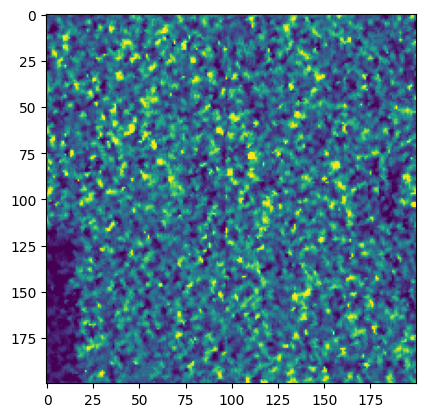

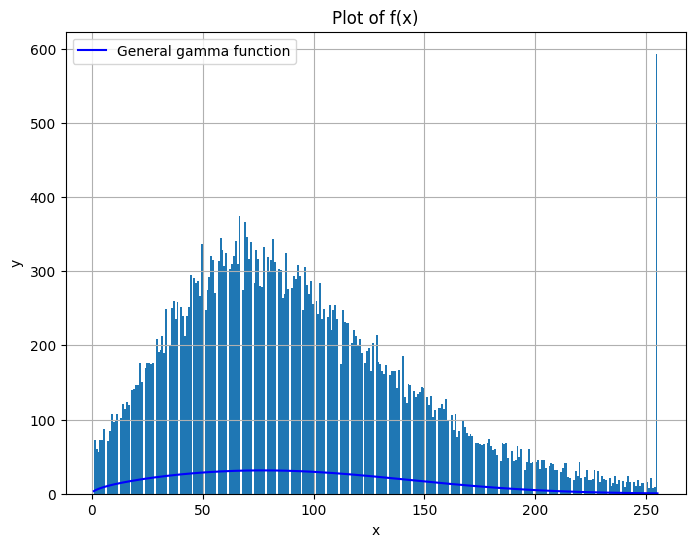

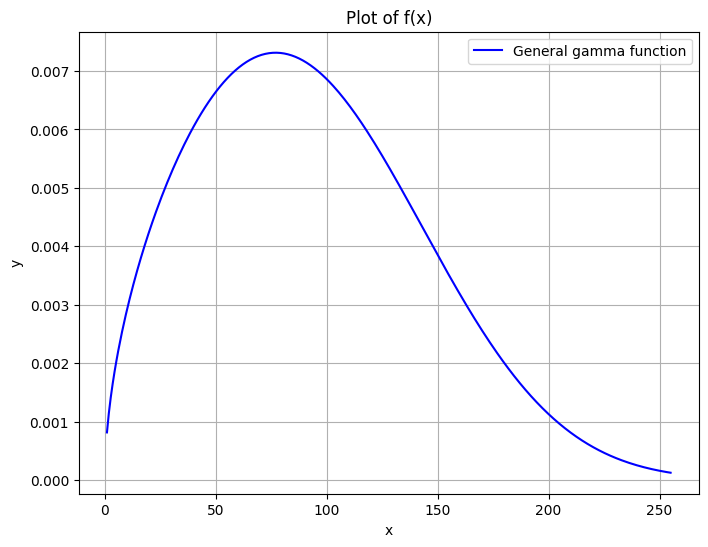

In [74]:
seg4 = vv[0:200, 600:800]
plt.imshow(seg4)
gama4 = GeneralizedGamma(seg4, True, True)

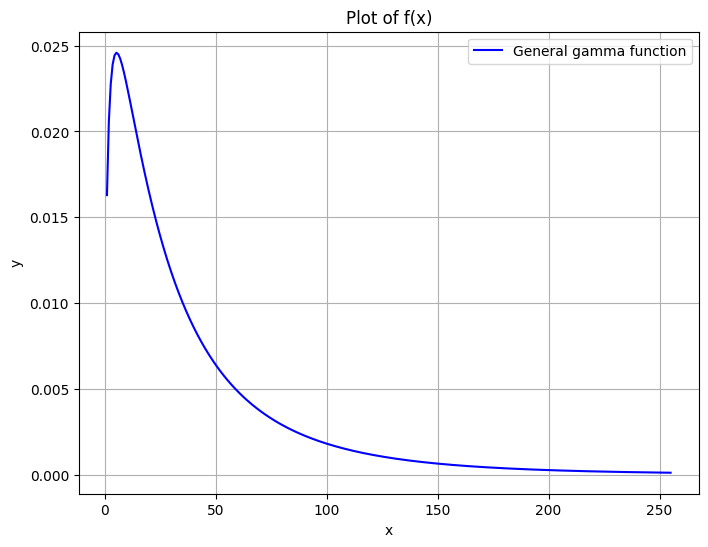

In [22]:
gama1.plot_pure()

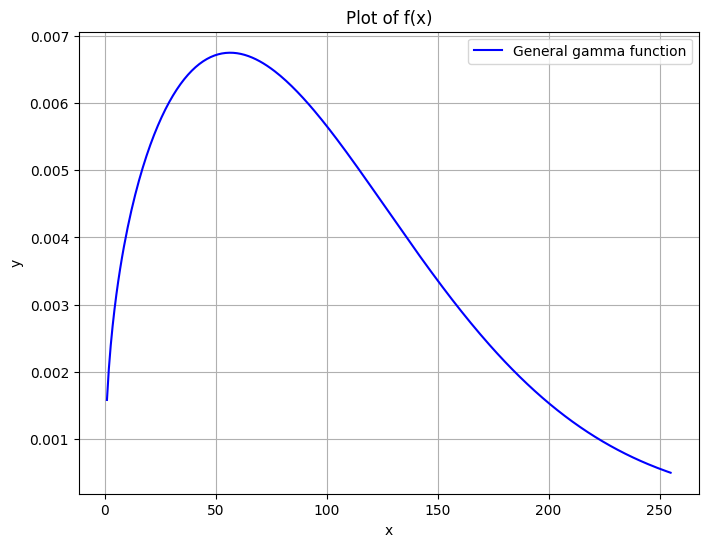

In [23]:
gama3.plot_pure()

Número de pixels: 18520
sigma = 30.994417092709803
kappa = 4.109771315834825
v = 0.446514174760206


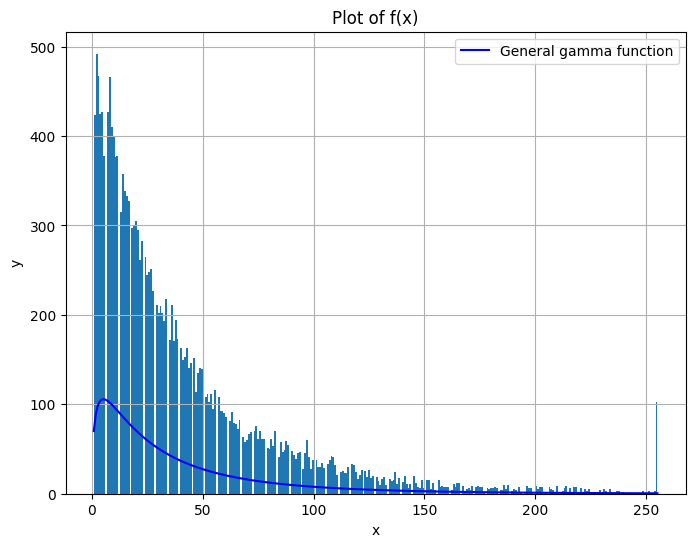

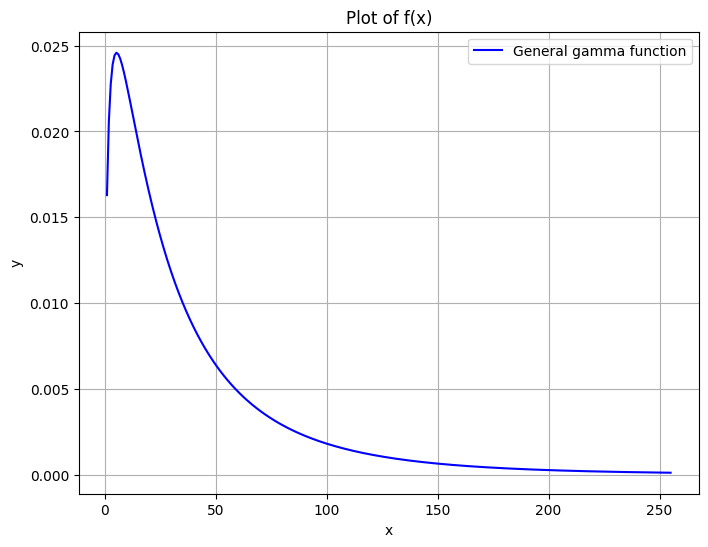

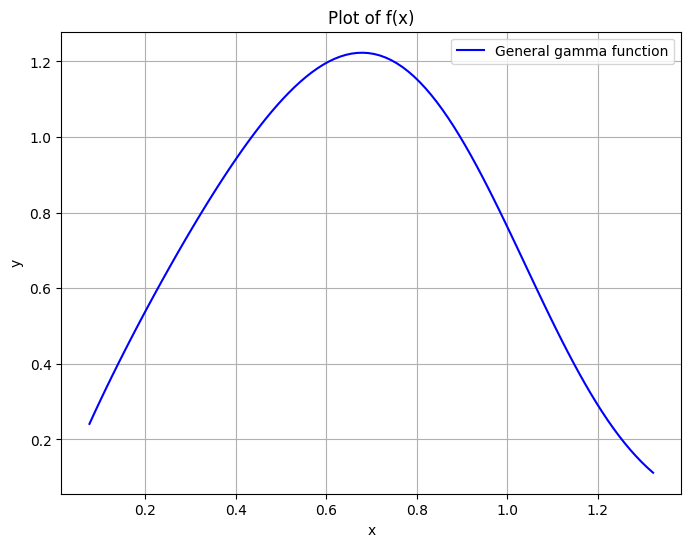

In [52]:
gama1 = GeneralizedGamma(seg1, True, True)
gama1.plot_scipy()

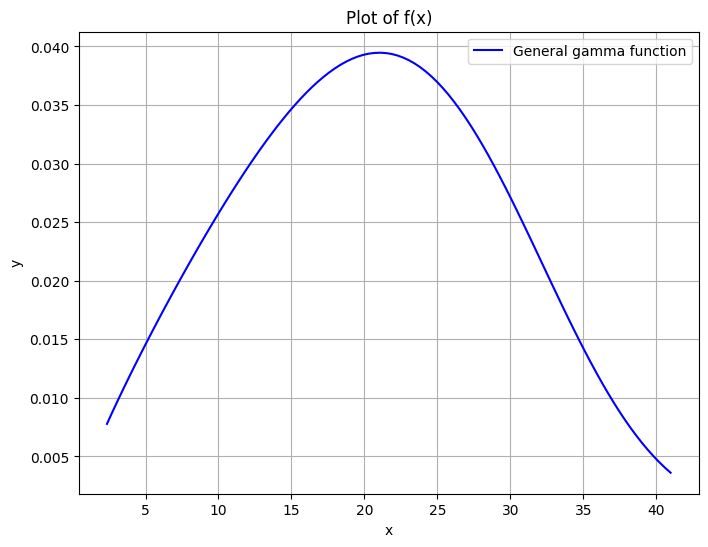

In [59]:
gama1 = GeneralizedGamma(seg1)
gama1.plot_scipy_scaled()

Número de pixels: 38681
sigma = 111.9591804956696
kappa = 0.791028672671812
v = 1.7906933755068333


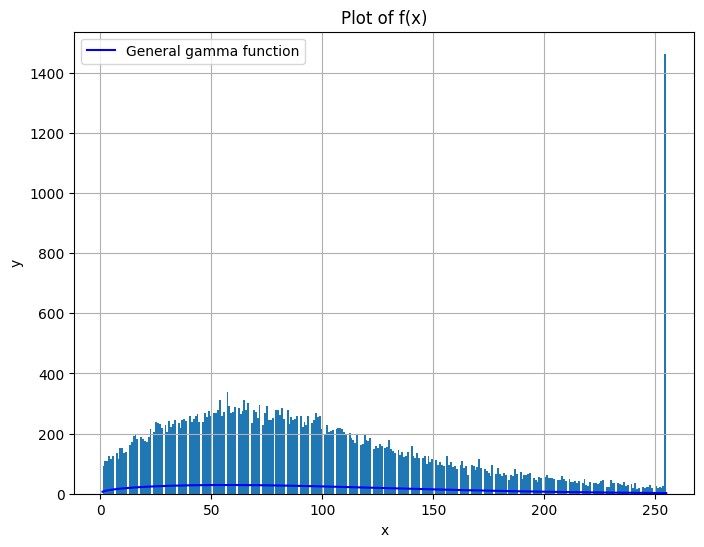

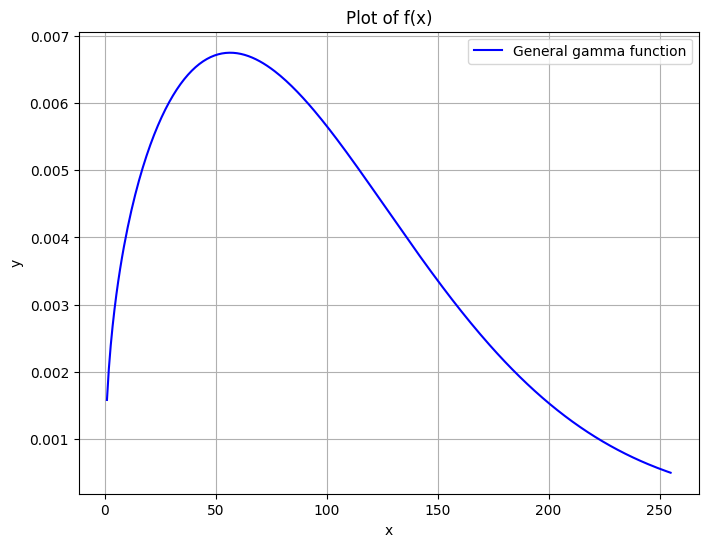

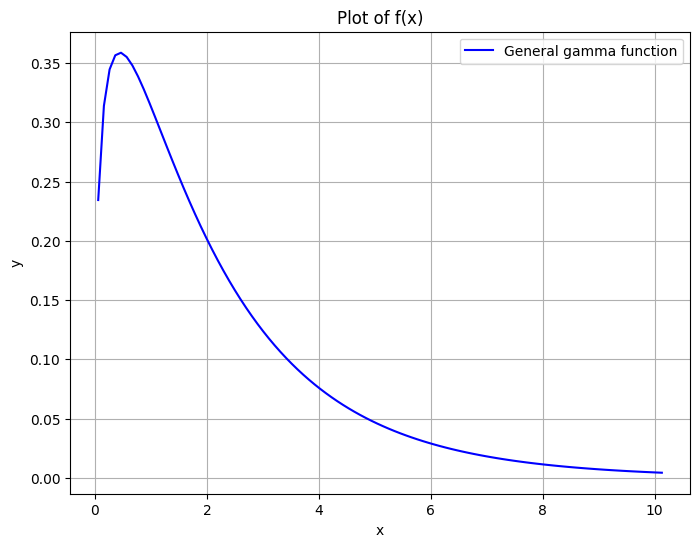

In [60]:
gama3 = GeneralizedGamma(seg3, True, True)
gama3.plot_scipy()

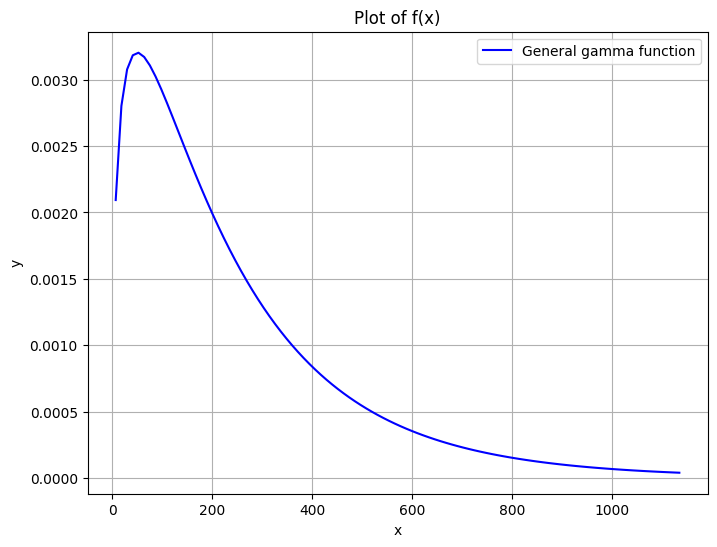

In [57]:
gama3.plot_scipy_scaled()

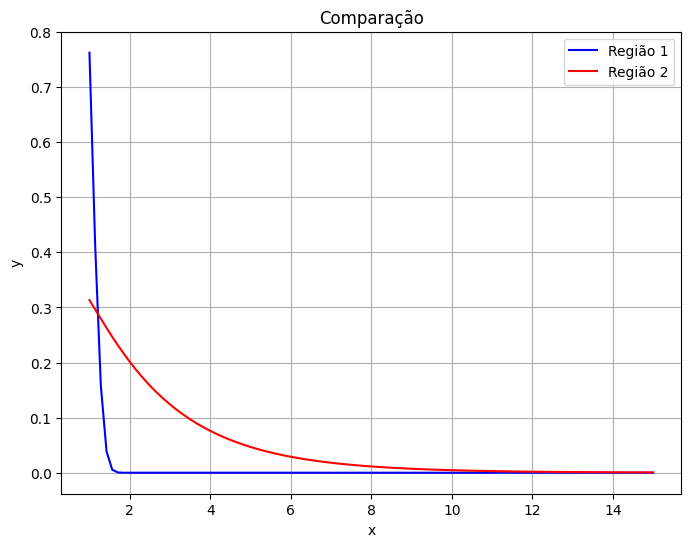

In [72]:
gama1 = GeneralizedGamma(seg1)
gama3 = GeneralizedGamma(seg3)

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

x1, y1 = gama1.return_scipy_data()
x2, y2 = gama3.return_scipy_data()

plt.plot(x1, y1, label='Região 1', color='blue')  # Plot the function
plt.plot(x2, y2, label='Região 2', color='red')  # Plot the function
plt.xlabel('x')  # Label for the x-axis
plt.ylabel('y')  # Label for the y-axis
plt.title('Comparação')  # Title of the plot
plt.legend()  # Display the legend
plt.grid(True)  # Enable gridlines



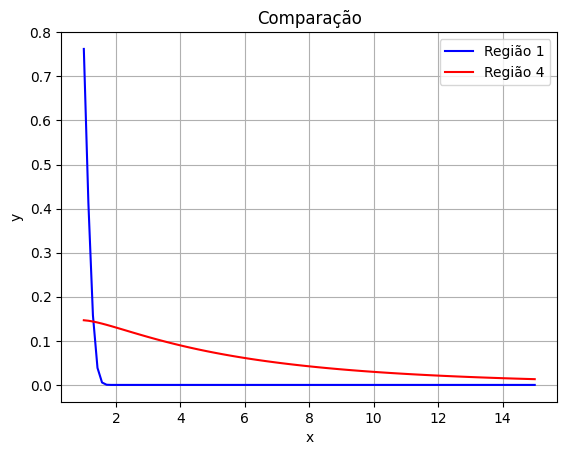

In [75]:
x1, y1 = gama1.return_scipy_data()
x2, y2 = gama4.return_scipy_data()

plt.plot(x1, y1, label='Região 1', color='blue')  # Plot the function
plt.plot(x2, y2, label='Região 4', color='red')  # Plot the function
plt.xlabel('x')  # Label for the x-axis
plt.ylabel('y')  # Label for the y-axis
plt.title('Comparação')  # Title of the plot
plt.legend()  # Display the legend
plt.grid(True)  # Enable gridlines

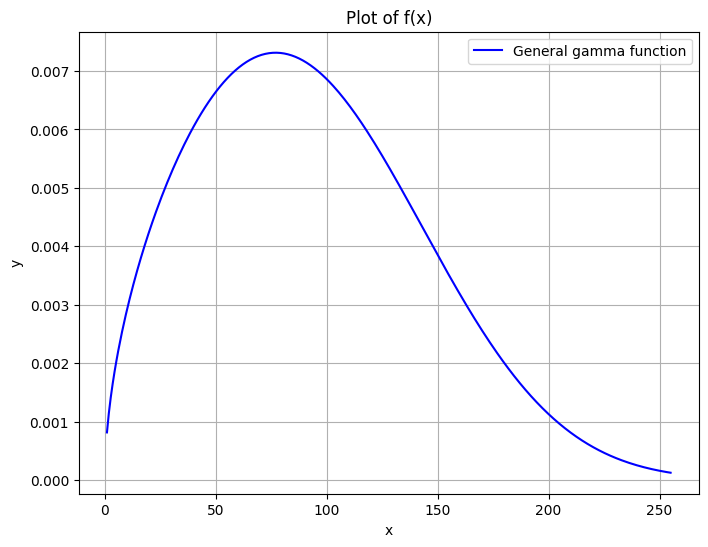

In [79]:
gama4.plot_pure()

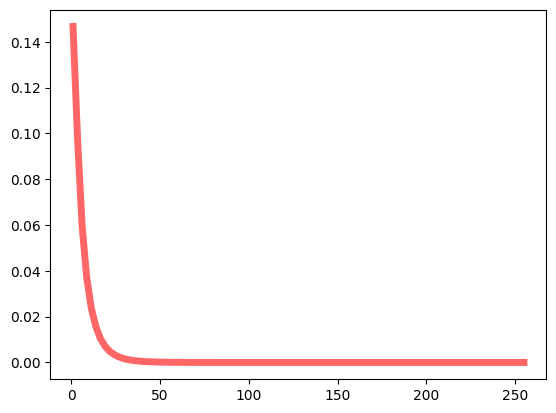

In [84]:
fig, ax = plt.subplots(1, 1)
a = gama4.v_hat
c = gama4.kappa_hat
s = gama4.sigma_hat
x = np.linspace(1, 255,  100)

ax.plot(x, gengamma.pdf(x, a, c),

       'r-', lw=5, alpha=0.6, label='gengamma pdf')

In [89]:
gama4 = GeneralizedGamma(seg4)
gama4.plot_normalized()

RecursionError: maximum recursion depth exceeded

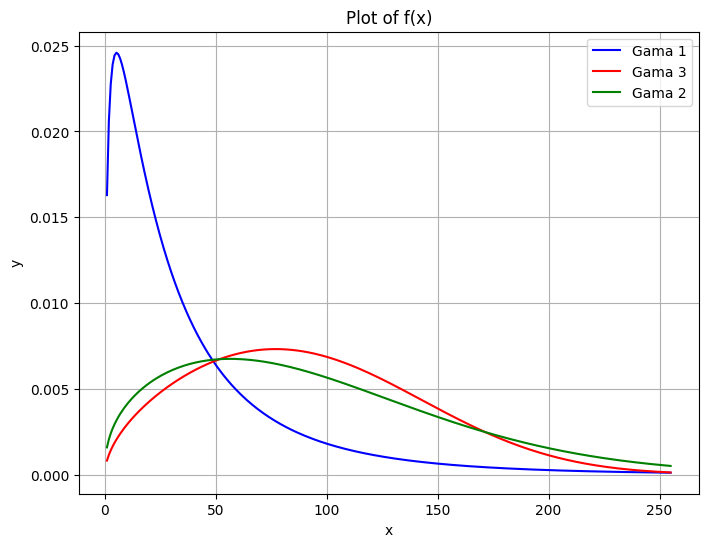

In [90]:
x = np.linspace(1, 255, 300)
y_1 = gama1.function_value(x)
y_2 = gama3.function_value(x)
y_3 = gama4.function_value(x)


plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x, y_1, label='Gama 1', color='blue')  # Plot the function
plt.plot(x, y_3, label='Gama 3', color='red')  # Plot the function
plt.plot(x, y_2, label='Gama 2', color='green')  # Plot the function
plt.xlabel('x')  # Label for the x-axis
plt.ylabel('y')  # Label for the y-axis
plt.title('Plot of f(x)')  # Title of the plot
plt.legend()  # Display the legend
plt.grid(True)  # Enable gridlines